# <center> Adherence in a RCT mHealth dataset </center>

### Introduction
Dieses Notebook stellt verschiedene Algorithmen zur Analyse des Adherence Verhaltens von Personen aus einem gegebenen Datensatz zur Verfügung.

### Imports
Damit wir alle benötigten Algorithmen und Funktionen auch aufrufen können, importieren wir zunächst alle Python Dateien, in denen unser Code geschrieben steht.

In [1]:
import os.path
import sys
sys.path.insert(0, os.path.normpath(os.getcwd() + os.sep + os.pardir))
sys.path.insert(0, os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + "data"))
sys.path.insert(0, os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + "util"))
sys.path.insert(0, os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + "notebook"))


from util import helper as hlp
from util import setup as set
from util import task1_phases as pha
from util import task2_groups as grp
from util import task3_prediction as pred
from util import task4_statistics as stat
from util import task5_adherence_level as lev
from util import task5_adherence_level_helper as lev2

import pandas as pd
import matplotlib.pylab as plt
pd.options.mode.chained_assignment = None  # default='warn'
import warnings

# FutureWarning-Warnungen ignorieren
warnings.filterwarnings("ignore", category=FutureWarning)

### Read in data
Zuerst lesen wir den Datensatz als pandas DataFrame ein. Der Datensatz muss in einem CSV-Format vorliegen. Der Name der Datei muss dafür vorher in der Datei setup.py angegeben werden (Direkt nach s_file_name = ).

In [2]:
# Suchen des Pfades in dem der Datensatz gespeichert ist. Der Datensatz wird anschließen in ein Panda Dataframe konvertiert
dataset = hlp.find_path(set.s_file_name)

### Data Preparation
Um mit dem Datensatz besser arbeiten zu können müssen wir diesen zunächst etwas anpassen. Dafür werden alle unnötigen Spalten aus dem DataFrame entfernt. Außerdem gruppieren wir alle user_ids, sodass die Daten eines Nutzers alle hintereinander stehen und nicht quer verteilt sind und sortieren die Daten nach Datum, sodass sie auch zeitlich richtig sortiert sind. Es wird zudem noch das Attribut day hinzugefügt, welches den Tag, ab dem ältesten Datum für einen Nutzer angibt.

In [3]:
# Gruppieren des DataFrame nach user_id und Sortieren nach collected_at
df_sorted = hlp.data_preparation(dataset)
df_sorted.head()

,id,user_id,locale,client,collected_at,value_loudness,value_cumberness,value_jawbone,value_neck,value_tin_day,value_tin_cumber,value_tin_max,value_movement,value_stress,value_emotion,value_diary_q11,collected_at_year,collected_at_month,collected_at_time,day
0,4,101,en,"{""device"":""iPhone"",""os"":""iOS 14.3"",""name"":""UNI...",2021-04-14 08:21:51+00:00,75,79,82,71,67,82,78,78,71,67,0,2021,4,501,1
1,5,101,en,"{""os"":""iOS 14.3"",""device"":""iPhone"",""name"":""UNI...",2021-04-14 08:23:12+00:00,33,77,76,64,21,73,65,30,92,67,1,2021,4,503,1
2,9489,101,de,"{""device"":""iPhone"",""os"":""iOS 14.6"",""name"":""UNI...",2021-07-19 13:20:30+00:00,24,73,83,53,20,85,57,25,73,82,0,2021,7,800,97
3,9491,101,en,"{""device"":""iPhone"",""os"":""iOS 14.5"",""name"":""UNI...",2021-07-19 13:27:01+00:00,35,28,23,20,50,37,32,27,44,45,0,2021,7,807,97
4,9515,101,el,"{""os"":""iOS 14.6"",""name"":""UNITI 1.0.2"",""device""...",2021-07-19 14:59:32+00:00,23,75,28,69,16,87,28,81,28,77,1,2021,7,899,97


Im Folgenden filtern wir einen Testnutzer aus unserem Datensatz heraus, der anstelle eines echten neuen Nutzers benutzt wird. Alternativ kann natürlich auch ein echter Nutzer eingesetzt werden. Dafür muss der Dateiname in der Setup-Datei hinter s_file_newuser geändert werden. Außerdem können für den Testnutzer alle Einträge nach Tag y entfernt werden, um berechnete Werte von den gefilterten Daten mit den echten Daten zu vergleichen.

In [4]:
# Suchen des Pfades vom neuen Nutzers
df_newuser = hlp.find_path(set.s_file_newuser)

# Entfernen des Nutzers aus dem Datensatz (falls es er im Datensatz vorhanden ist)
df_sorted = hlp.delete_test_user(df_sorted, df_newuser.iloc[0]['user_id'])

# Kürzen der Einträge des Nutzers (falls Testnutzer) um die Ergebnisse der prediction mit dem echten Wert zu vergleichen
y = 80
df_newuser_filtered = hlp.filter_df_newuser(df_newuser, y)
df_newuser_filtered.head()

,id,user_id,locale,client,collected_at,value_loudness,value_cumberness,value_jawbone,value_neck,value_tin_day,value_tin_cumber,value_tin_max,value_movement,value_stress,value_emotion,value_diary_q11,collected_at_year,collected_at_month,collected_at_time,day
0,1104,2107,en,"{""name"":""UNITI 1.0"",""os"":""iOS 14.5.1"",""device""...",2021-05-14 15:48:21+00:00,35,3,0,0,32,30,39,86,19,78,1,2021,5,948,1
1,1162,2107,de,"{""os"":""iOS 14.5.1"",""name"":""UNITI 1.0"",""device""...",2021-05-15 17:32:52+00:00,35,18,0,0,33,20,43,37,0,71,1,2021,5,1052,2
2,1217,2107,de,"{""os"":""iOS 14.5.1"",""name"":""UNITI 1.0"",""device""...",2021-05-16 17:31:08+00:00,37,31,0,0,35,22,46,58,10,73,1,2021,5,1051,3
3,1298,2107,de,"{""os"":""iOS 14.5.1"",""device"":""iPhone"",""name"":""U...",2021-05-17 19:12:20+00:00,26,22,0,5,34,19,35,57,21,73,1,2021,5,1152,4
4,1299,2107,de,"{""os"":""iOS 14.5.1"",""device"":""iPhone"",""name"":""U...",2021-05-17 19:13:10+00:00,22,28,0,0,31,28,36,56,21,72,0,2021,5,1153,4


### Phases
Sie können sich die den Adherence Verlauf einer einzelnen Person ausgeben lassen um direkt zu erkennen wie sich der Nutzer verhalten hat. Eine User Timeline ist die Bezeichnung für eine binäre Liste für die folgendes gilt: 0 = Der Nutzer hat die App an Tag X nicht genutzt, 1 = Der Nutzer hat die App an Tag X genutzt. Der erste Eintrag der Liste steht für den ersten Tag der Nutzung der App, der zweite Eintrag für den zweiten Tag, usw.

In [5]:
user40176_timeline = pha.get_user_timeline(df_sorted, 40176)

Möchten Sie mehr als einen User auswerten, brauchen Sie zuerst eine Liste mit allen UserIDs aus ihrem Datensatz. Diese UserIDs bekommen Sie mit der  Methode 'get_user_ids'.

In [21]:
all_userids = hlp.get_user_ids(df_sorted)

Um zu den Verlauf der Nutzung der App zu analysieren, müssen Sie zuerst wissen an welchen Tagen die Nutzung der App besonders hoch oder niedrig war. Dazu können Sie sich mit der Methode 'get_all_adherence_percentage' die prozentuale Nutzung der App ausgeben lassen. Zuvor biete es sich an einmal die Methode 'get_all_user_timelines' auszurufen um alle User Timelines

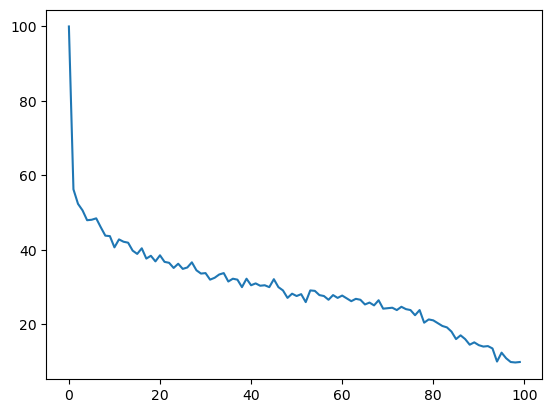

In [22]:
all_timelines = pha.get_all_user_timelines(df_sorted)

adherence_percentages = pha.get_all_adherence_percentage(all_timelines)

plt.plot(adherence_percentages)
plt.show()

Nun sind alle Voraussetzungen erfüllt um den Datensatz auf das Vorhandensein von Phasen zu untersuchen. Dafür nutzt dieses Paket drei verschiedene CPD-Algorithmen zur aus dem Ruptures package (CPD = Change point detection). Die gefundenen Change Points der drei Algorithmen geben an, in welche Phasen sich der zeitliche Verlauf unterteilt.
1. Binary Segmentation
2. Bottom-Up Segmentation
3. Window Segmentaion

Bevor Sie die Algorithmen anwenden, müssen Sie angeben noch welchen Kriterien Sie Chane Points suchen.
Wenn Sie eine feste Anzahl an Change Points suchen, müssen Sie folgende Einstellungen vornehmen:
    s_cpd_mode: True = Feste Anzahl an Change Points
    s_num_change_points: Anzahl der Change Points

In [8]:
set.s_cpd_mode = True
set.s_num_change_points = 3

Soll die Anzahl der Change Points dynamisch sein, sollten Sie einen Schwellenwert angeben und folgende Einstellungen vornehmen:
    s_cpd_mode: False = Schwellenwert für die Bestimmung von Change Points
    s_pen_change_points: Höhe des Schwellenwerts für die Bestimmung der Change Points

In [9]:
set.s_cpd_mode = False
set.s_pen_change_points = 2

Da nun die notwendigen Einstellungen vorgenommen wurden, können Sie die Phasen mit Hilfe der CPD-Algorithmen bestimmen.

In [10]:
result_binseg = pha.cpd_binseg(adherence_percentages)

result_botupseg = pha.cpd_botupseg(adherence_percentages)

result_windowseg = pha.cpd_windowseg(adherence_percentages)

print(result_binseg)
print(result_botupseg)
print(result_windowseg)

[17, 46, 81, 100]
[9, 48, 84, 100]
[79, 100]


## Groups
Sie können sich aus dem Datensatz Patientengruppen mit ähnlichem Verhalten mittels Clustering identifizieren lassen. Dabei existieren verschiedene Möglichkeiten der Gruppierung. Darunter nach dem Adherence-Verhalten, dem Nutzungsverhalten oder eine Kombinierte Gruppierung beider Faktoren. Des weiteren besteht die Möglichkeit keine Gruppierung zu nutzen. Jedem Patienten wird somit seine Gruppenzugehörigkeit zugeordnet aufgrund der jeweiligen vom Nutzer getätigten Auswahl der Gruppierung.

Werden die Patienten nach ihrem Adherence-Verhalten geclustert, so gibt es drei Möglichkeiten dies vorzunehmen. 
Bei Möglichkeit 1 wird die individuelle Adeherenz-Timeline des Patienten aus Task 1 genutzt um festzustellen an welchen Tagen er adherent war und an welchen nicht. 
Möglichkeit 2 clustert aufgrund des festgestellten Adherence-Percentages zu jeder Phase für jeden Patienten aus Task 3. 
Möglichkeit 3 nutzt die individuelle Notiz-Timeline eines Patienten und stellt somit fest an welchen Tagen die Notizfunktion genutzt wurde und welche Patienten sich dabei ähneln. Alle Clusterings erfolgen mit KMeans.

In [12]:
user_id = 2222
result_phases = result_binseg
allusers_phases = pred.get_allusers_adherence(df_sorted, result_phases)

# Methode 1
cluster_timelines = grp.cluster_timelines(df_sorted)
cluster_timelines_user = cluster_timelines[cluster_timelines[set.s_table_key] == user_id]
print(cluster_timelines_user)

# Methode 2
cluster_adherence = grp.cluster_adherence_percentages(allusers_phases)
cluster_adherence_user = cluster_adherence[cluster_adherence[set.s_table_key] == user_id]
print(cluster_adherence_user)

# Methode 3
cluster_note_timelines = grp.cluster_note_timelines(df_sorted)
cluster_note_timelines_user = cluster_note_timelines[cluster_note_timelines[set.s_table_key] == user_id]
print(cluster_note_timelines_user)

C:\Users\mauri\anaconda3\envs\Softwareprojekt\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


   user_id                                           timeline cluster_label
76    2222  [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...             2


C:\Users\mauri\anaconda3\envs\Softwareprojekt\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


   user_id                       phases  cluster_label
76    2222  [0.882, 0.833, 0.343, 0, 0]              2


C:\Users\mauri\anaconda3\envs\Softwareprojekt\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


   user_id                                     notes_timeline cluster_label
76    2222  [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...             0


Werden die Patienten nach ihrem Nutzungsverhalten einem Cluster zugeordnet, so passiert dies aufgrund der eingegebenen Attributwerte. Dafür wird der Datens


In [13]:
patient_id_2222 = 2222
patient_data = grp.preprocess_data(df_sorted[df_sorted['user_id'] == patient_id_2222])
cluster_assignments, centroids = grp.k_pod(patient_data, k=3)

In [13]:
patient_id_2222 = 2222
user_clusters = grp.combine_cluster_assignments(df_sorted[df_sorted['user_id'] == patient_id_2222], allusers_phases, num_clusters=3)

C:\Users\mauri\anaconda3\envs\Softwareprojekt\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


IndexError: index 2222 is out of bounds for axis 0 with size 51

In [14]:
# Assuming you have a patient DataFrame named 'patient_data'
default_group_label = 1  # Replace with the desired default group label
patient_data_with_clusters = grp.assign_default_group_(patient_data, default_group_label)

AttributeError: module 'util.task2_groups' has no attribute 'assign_default_group_'

### Prediction of a users adherence behaviour
In dieser Task geht es darum die Adherence eines neuen Nutzers für einen bestimmten Tag y in der Zukunft vorherzusagen. Dies geschieht mithilfe der Daten des neuen Nutzers und mithilfe des Datensatzes.

#### Schritt 1
Zuerst lesen wir den Datensatz unseres neuen Nutzers ein. Den Datensatz für die restlichen Nutzer haben wir schon in df_sorted gespeichert. In result_phases wird ein beliebiges Verfahren aus Task 1 für die verschiedenen Phasen im Datensatz gewählt und es wird für den neuen Nutzer festgelegt wie seine Adherence in den jeweiligen Phasen war (Adherence-percentages). Das Gleiche wird für alle anderen Nutzer im Datensatz gemacht.

In [15]:
# Auswahl des Verfahrens aus Task 1 für die Ermittlung der Phasen im Datensatz und die Einordnung des Nutzers in die Phasen
result_phases = result_binseg

# Speichere die Adherence in den einzelnen Phasen für den neuen Nutzer und alle vorhandenen Nutzer
newusers_phases = pred.get_newusers_adherence(df_newuser_filtered, result_phases)
allusers_phases = pred.get_allusers_adherence(df_sorted, result_phases)

new users id: 2107
new users length: 79 days
number of phases: 3
new users adherence percentages: [0.882, 0.9, 0.824]


#### Schritt 2
In Schritt 2 wird im Datensatz nach ähnlichen Nutzern anhand der Adherence gesucht. Dafür wird der Datensatz nach den k-ähnlichsten Nutzern nach users_adherence abgesucht und der ursprüngliche Datensatz (df_sorted) wird nach diesen Nutzern gefiltert (df_similar_users).

In [16]:
# Variable für den knn-Algorithmus der nach den ähnlichsten Nutzern nach Adherence-Level sucht
k = 10

df_similarusers = pred.find_similar_users(df_sorted, newusers_phases, allusers_phases, k)

Die 10 ähnlichsten Nutzer sind:

    user_id                 phases  similarity
207    6352  [0.882, 0.867, 0.833]       0.034
285    6692  [0.882, 0.867, 0.806]       0.038
77     2226    [0.882, 0.9, 0.778]       0.046
215    6388    [0.882, 0.9, 0.778]       0.046
226    6436  [0.882, 0.933, 0.861]       0.050
523   40176    [0.941, 0.9, 0.833]       0.060
574   40414     [0.824, 0.9, 0.84]       0.060
202    6328  [0.824, 0.867, 0.833]       0.067
191    6276  [0.941, 0.933, 0.846]       0.071
205    6340  [0.882, 0.933, 0.889]       0.073


#### Schritt 3
Auf den ähnlichen Nutzern wird nun ein Modell trainiert, welches die Wahrscheinlichkeit für adherence an einem bestimmten Tag vorhersagen soll. Für dieses Modell wird eine k-fold-cross validation ausgeführt, um die Accuracy des Modells festzulegen. Diese dient als Maß zur Sicherheit der Korrektheit des Ergebnis. Zum Schluss wird mithilfe des Modells für alle Einträge unseres neuen Nutzers die Adherence-Wahrscheinlichkeit an Tag y berechnet. Diese setzt sich zu 50% aus dem Adherence Level des neuen Nutzers in den vorherigen Phasen zusammen und zu 50% aus der Vorhersage des Modells. Diese Wahrscheinlichkeit wird letztendlich ausgegeben.

In [17]:
# Auswahl des Tag y, für den die Adherence-Wahrscheinlichkeit berechnet werden soll
day_y = 90
# Variable für die k-fold-cross-valdation, mit der die Accuracy des Modells getestet wird
cv = 10
# Wahl des ML-Modells: 0 --> für RandomForest, 1 --> für Support Vector Machines
model = 0

pred.predict_day_adherence(df_similarusers, df_newuser_filtered, day_y, cv, 0)

Durchschnittliche Test Accuracy RandomForest-Modell: 0.899
Adherencewahrscheinlichkeit an Tag 90: 0.839


0.8394866385372715

tatsächliche Adherence an diesem Tag (falls Testnutzer):

In [18]:
hlp.is_adherent(df_newuser, day_y)

1

Zusätzlich gibt es noch die Möglichkeit sich die Adherence für den Nutzer über die zukünftigen Phasen ausgeben zu lassen. Dafür wird der Durchschnitt der ähnlichen Nutzer in diesen Phasen gebildet.

In [19]:
newusers_all_phases = pred.predict_phase_adherence(df_similarusers, allusers_phases, newusers_phases)

new users adherence percentages without future phases: [0.882, 0.9, 0.824]
new users adherence percentages with future phases: [0.882, 0.9, 0.824, 0.65, 0.329]


### Statistics
In dieser Task geht es darum die Phasen und die Gruppen aus Task 1 und 2, sowie einige weitere Statistiken zu einem bestimmten Nutzer in einer Übersicht darzustellen.

#### Users timeline
Mithilfe dieser Funktion kann die timeline eines bestimmten Nutzers visualisiert werden. Dabei geben schwarze Punkte die Tage vor, in denen der Nutzer adherent war und weiße Punkte die Tage, in denen der Nutzer nicht adherent war.

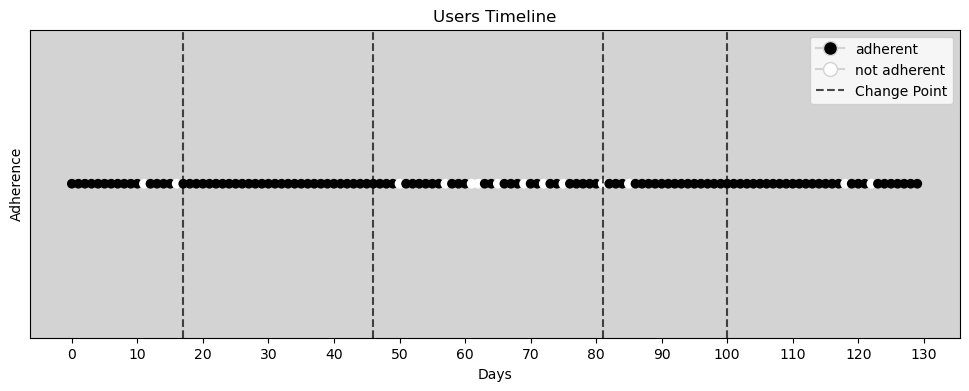

In [20]:
result_phases = result_binseg
user_id = 2192
stat.show_user_timeline(df_sorted, user_id, result_phases, start_day=1, end_day=130, step=10)

#### Clusters of the data set

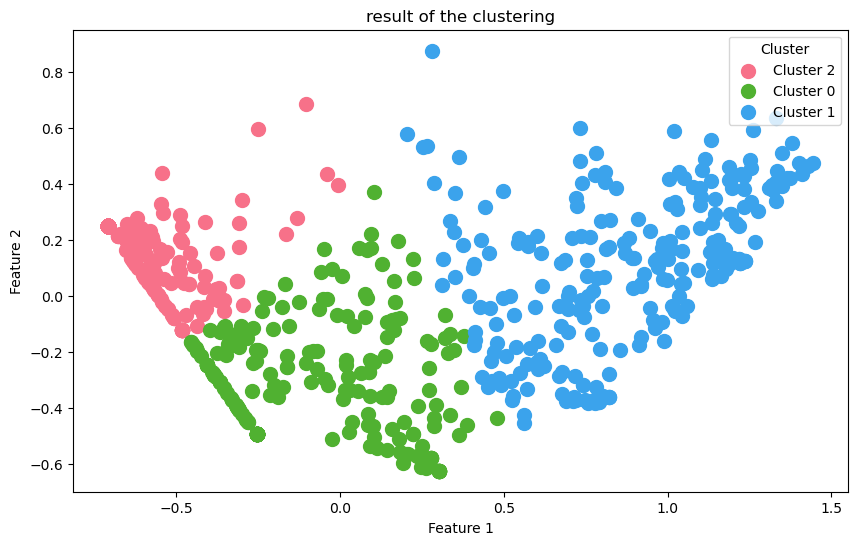

,Feature_1,Feature_2,cluster_label
0,-0.619001,0.280564,2
1,-0.218724,-0.007834,0
2,-0.625318,0.115644,2
3,-0.707822,0.251294,2
4,-0.707822,0.251294,2
...,...,...,...
790,-0.513348,-0.068453,2
791,-0.556867,0.003099,2
792,-0.481162,-0.121371,2
793,-0.707822,0.251294,2


In [21]:
stat.show_users_clusters(cluster_adherence)

#### Users adherence percentage
Hier wird die adherence percentage in jeder einzelnen Phase zu einem Nutzer im Datensatz angegeben.

[0.882, 0.967, 0.778, 0.9, 0.873]


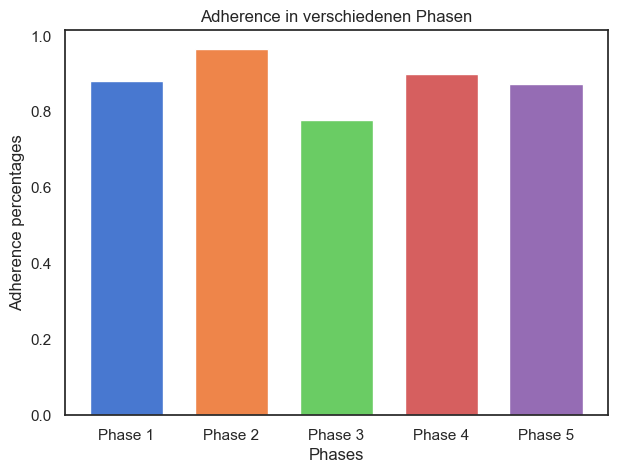

In [25]:
stat.show_user_adherence_percentage(allusers_phases, user_id)

Natürlich kann das auch für den neuen Nutzer angegeben werden. Es muss nur new_users_all_phases übergeben werden.

[0.882, 0.9, 0.824, 0.65, 0.329]


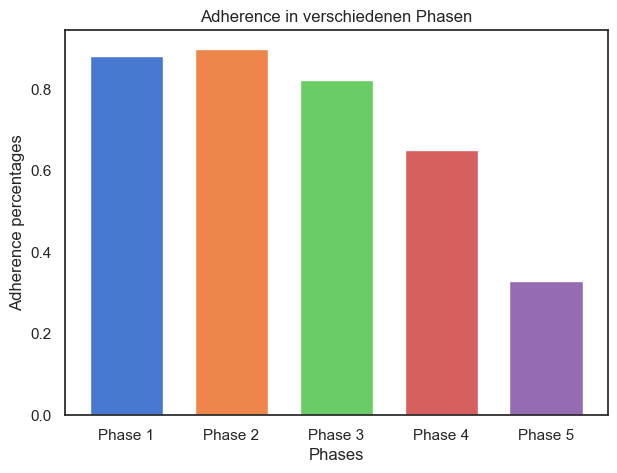

In [24]:
stat.show_user_adherence_percentage(newusers_all_phases)

#### Users statistics
Mit dieser Funktion werden statistische Daten eines Nutzers aus dem Datensatz analysiert und ausgegeben.

In [23]:
users_stats = stat.show_user_statistics(df_sorted, user_id)
users_stats.head()

,user_id,Anzahl_Tage,Anzahl_Einträge,Anzahl_fehlende_Einträge,längster_adh_Streak,adh_percentage,Anzahl_Lücken
0,2192,154,135,19,33,0.96,18


### Task 5 Adherence Level

#### Get User adherence percentage

get_user_adh_percentage(df_sorted, user_id, start_day=None, end_day=None, column=s_table_sort_by):

adh_percentage wird berechent aus der Anzahl an adherenten Tagen in der Timeline / Anzahl aller Tage in der Timeline
start_day und end_day angeben wie in get_user_timeline() um adh_percentage in einer bestimmten timeline zu bekommen. Stanadard mäßig gesamte timeline.
returned adh_percentage eines bestimmten Users in einer bestimmten Timeline als float Wert.

In [5]:
id_user = 2192

start_day = 20
end_day = 120
column = set.s_table_sort_by

lev.get_user_adh_percentage(df_sorted,id_user,start_day,end_day)

0.8910891089108911

#### Get User adherence level

get_user_adh_level(df_sorted, adh_level, full_adh_threshold=80, non_adh_threshold=40, start_day=None, end_day=None) :

Labeled user nach ihren adh_level. 3 Gruppen: Fully adherent, partially adheren, non-adherent.
Über adh_level gibt der User an, welche von den Gruppen er haben möchte.
1 = non-adherent; 2 = partial; 3 = fully adherent. User kann auch angeben, welchen Threshold er haben möchte für die adh_level. Also bis wieviel Prozent adh_percentage ein
User noch als fully_adherent gilt, oder bis wie viel Prozent adh_percentage ein User noch als non-adherent gilt. Standardmäßg ist der Threshold bei 80 Prozent für fully
adherent und 40 Prozent bei non-adherent.
Über start_day und end_day kann der user wieder angeben, in welcher bestimmten timeline er das adh_level bestimmen möchte, wobei wieder standardmäßig gesamte timeline
benutzt wird.
returned ein Array von Usern, welche die Eingabekriterien erfüllen. Also welches von den 3 adh_level und in welche Timeline und mit welcher Threshold.

In [6]:
adh_level = 3
full_adh_threshold = 80
non_adh_threshold = 40
start_day = 20
end_day = 120

non_adherent = []
non_adherent = lev.get_user_adh_level(df_sorted, adh_level, full_adh_threshold, non_adh_threshold,start_day,end_day)
print(non_adherent)

[2146, 2192, 2260, 2385, 2429, 2461, 4136, 4144, 6152, 6216, 6264, 6284, 6316, 6332, 6340, 6360, 6436, 6452, 6460, 6484, 6488, 6540, 6544, 6596, 6624, 6636, 6680, 6692, 34137, 34165, 34183, 34325, 34331, 34342, 34350, 34362, 34400, 34470, 38139, 40125, 40138, 40203, 40313, 42415, 42528]


### Get User adherence level Cluster

get_user_adh_level_cluster(df_sorted, adh_level, start_day=s_start_day, end_day=s_end_day):

Labeled user nach adh_level basiert auf k-means clustering mit k=3. Benutzt wird cluster_adherence_levels(df_sorted, num_clusters=3, start_day=None, end_day=None)
aus task2_groups. Den Clustern wird ein adherence level label gegeben. Der Nutzer kann entscheiden mit adh_level welchen adherence level er haben möchte und bekommt ein
array von Usern mit dem adherence level.
adh_level of 1 = low adherence, 2 = moderate, 3 = high

In [7]:
adh_level = 1
start_day = 20
end_day = 120

low_adherence = []
low_adherence = lev2.get_user_adh_level_cluster(df_sorted, adh_level, start_day, end_day)
print(low_adherence)

C:\Users\mauri\anaconda3\envs\Softwareprojekt\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 50, 54, 55, 59, 62, 63, 64, 72, 73, 79, 80, 85, 89, 90, 93, 95, 97, 98, 102, 104, 106, 107, 109, 133, 135, 136, 140, 141, 142, 143, 144, 147, 157, 161, 163, 164, 167, 170, 171, 173, 174, 176, 177, 181, 182, 183, 184, 185, 194, 196, 197, 200, 208, 211, 212, 214, 217, 220, 224, 225, 227, 228, 231, 234, 235, 237, 241, 242, 244, 246, 249, 250, 255, 257, 258, 259, 262, 263, 266, 267, 269, 273, 275, 276, 278, 279, 280, 281, 283, 284, 288, 290, 293, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 308, 310, 311, 312, 314, 315, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 343, 350, 351, 352, 353, 354, 357, 362, 363, 370, 381, 383, 384, 386, 387, 392, 394, 401, 402, 405, 406, 409, 413, 414, 417, 418, 421, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 442, 443,